In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2
import glob
from natsort import natsorted
from matplotlib import pyplot as plt
import random
import wandb

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [3]:
def load_dataset(path):
    # Load the RAM from the experiment source into an array
    ram_files = glob.glob(f"{path}/RAM/*")

    # Load the buttons from the experiment source into an array
    buttons_files = glob.glob(f"{path}/Buttons/*")

    # Sort both arrays with natsort to make their indexes match
    rams_files = natsorted(ram_files)
    button_files = natsorted(buttons_files)

    # Load them rams
    rams = []
    for f in rams_files:
        rams.append(np.fromfile(f, dtype='uint8'))
    # Load them buttons
    buttons = []
    for f in button_files:
        buttons.append(np.fromfile(f, dtype='bool'))

    # Numpy array them and take a look at their shapes
    rams = np.array(rams)
    print(f"rams shape: {rams.shape}")

    buttons = np.array(buttons)
    print(f"buttons shape: {buttons.shape}")

    return rams, buttons

In [4]:
# Get the data from the reveal-more-redux directory
rom_name = "SuperMarioWorld-Snes"
train = "SMW_1"
test = "SMW_3"
experiment_source = "BK2Analysis"
data_dir = f"../reveal-more-redux/GameplayData/{rom_name}"
time_skip = 20
print(data_dir)

train_ram, train_buttons = load_dataset(f"{data_dir}/{train}/{experiment_source}")

test_ram, test_buttons = load_dataset(f"{data_dir}/{test}/{experiment_source}")

print(f"Loaded {len(train_ram)} ram files and {len(train_buttons)} button files for the train set")
print(f"Loaded {len(test_ram)} ram files and {len(test_buttons)} button files for the test set")


../reveal-more-redux/GameplayData/SuperMarioWorld-Snes
rams shape: (9589, 8192)
buttons shape: (9589, 12)
rams shape: (4562, 8192)
buttons shape: (4562, 12)
Loaded 9589 ram files and 9589 button files for the train set
Loaded 4562 ram files and 4562 button files for the test set


In [5]:
# R | L | X | A | Right | Left | Y | B | Select | Start | Up | Down |

In [6]:
# embed_mem model
latent_size = 128
mem_shape = train_ram.shape[1]
buttons_shape = train_buttons.shape[1] 

# Single linear layer, no activation, with l2 regularization
ram_input_layer = tf.keras.layers.Input(shape=(mem_shape))
x = ram_input_layer
# for i in range(3):
#     x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x)
embedding = tf.keras.layers.Dense(
    latent_size, 
    kernel_regularizer=None, 
    kernel_initializer='zeros', 
    name="mem_embedding_layer", 
    use_bias=False)(x)
# embedding = tf.keras.layers.Dense(latent_size, kernel_regularizer=None, name="mem_embedding_layer")(x)


embed_mem_model = tf.keras.Model(ram_input_layer, embedding)

embed_mem_model.compile()
embed_mem_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8192)]            0         
_________________________________________________________________
mem_embedding_layer (Dense)  (None, 128)               1048576   
Total params: 1,048,576
Trainable params: 1,048,576
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Button Predict model

current_input = tf.keras.layers.Input(shape=(latent_size))
goal_input = tf.keras.layers.Input(shape=(latent_size))

x = tf.keras.layers.Concatenate()([current_input, goal_input])
# x = current_input
for i in range(3):
    x = tf.keras.layers.Dense(
        256, 
        activation='tanh', 
        kernel_regularizer='l2')(x)
buttons_layers = tf.keras.layers.Dense(12, 
    activation='sigmoid')(x)
buttons_model = tf.keras.Model([current_input, goal_input], buttons_layers)

buttons_model.compile()
buttons_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          65792       concatenate[0][0]     

In [8]:
# memmem2buttons model
print(mem_shape)
current_mem_inputs = tf.keras.layers.Input(shape=(mem_shape))
goal_mem_inputs = tf.keras.layers.Input(shape=(mem_shape))

current_latent = embed_mem_model(current_mem_inputs)
goal_latent = embed_mem_model(goal_mem_inputs)

predict_buttons = buttons_model([current_latent, goal_latent])
memmem2buttons = tf.keras.Model([current_mem_inputs, goal_mem_inputs], predict_buttons)

memmem2buttons.compile(loss="binary_crossentropy", metrics=["binary_crossentropy"])
memmem2buttons.summary()

8192
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 8192)]       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 8192)]       0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 128)          1048576     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 12)           200460      functional_1[0][0

In [9]:
# Fit?
train_inputs = [train_ram[:-time_skip], train_ram[time_skip:]]
train_outputs = train_buttons[:-time_skip]
# test_inputs = [test_ram[:-time_skip], test_ram[time_skip:]]
test_inputs = [test_ram[:-time_skip], test_ram[:-time_skip]]
test_outputs = test_buttons[:-time_skip]

result = memmem2buttons.fit(train_inputs, train_outputs, validation_data=(test_inputs, test_outputs),epochs=40, batch_size=128, verbose=1)

Epoch 1/40
75/75 [==============================] - 0s 6ms/step - loss: 2.9215 - binary_crossentropy: 0.2203 - val_loss: 0.6568 - val_binary_crossentropy: 0.1968
Epoch 2/40
75/75 [==============================] - 0s 4ms/step - loss: 0.3238 - binary_crossentropy: 0.2071 - val_loss: 0.2062 - val_binary_crossentropy: 0.1902
Epoch 3/40
75/75 [==============================] - 0s 4ms/step - loss: 0.2146 - binary_crossentropy: 0.2034 - val_loss: 0.2082 - val_binary_crossentropy: 0.1988
Epoch 4/40
75/75 [==============================] - 0s 4ms/step - loss: 0.2208 - binary_crossentropy: 0.2099 - val_loss: 0.1966 - val_binary_crossentropy: 0.1878
Epoch 5/40
75/75 [==============================] - 0s 4ms/step - loss: 0.2091 - binary_crossentropy: 0.2021 - val_loss: 0.1953 - val_binary_crossentropy: 0.1895
Epoch 6/40
75/75 [==============================] - 0s 4ms/step - loss: 0.2080 - binary_crossentropy: 0.2022 - val_loss: 0.1941 - val_binary_crossentropy: 0.1892
Epoch 7/40
75/75 [==========

In [12]:
embed_mem_model.save("embed_mem_model.h5")
buttons_model.save("buttons_model.h5")
result.model.save("turbocharger.h5")

In [15]:
memmem2buttons.evaluate(train_inputs, train_outputs[::-1])

300/300 [==============================] - 0s 1ms/step - loss: 0.1987 - binary_crossentropy: 0.1985


[0.19865655899047852, 0.198496013879776]

In [54]:
# 0 hidden layers: 5.1655 - val_loss: 5.1569
# 1 hidden layer: 5.2031 - val_loss: 5.1999
# 2 hidden layer: 0.2161 - val_loss: 0.1754
# 3 hidden layer: 0.2146 - val_loss: 0.1919
# 4 hidden layer: 0.2005 - val_loss: 0.1903
# 5 hidden layer: 0.1996 - val_loss: 0.1717
# 5 hidden layer 256w: 0.1925 - val_loss: 0.1835

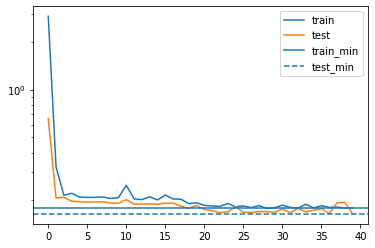

In [10]:
plt.plot(result.history['loss'], label="train")
plt.plot(result.history['val_loss'], label="test")
plt.axhline(np.min(result.history['loss']), label="train_min")
plt.axhline(np.min(result.history['val_loss']), label="test_min", linestyle='dashed')
plt.yscale('log')
# plt.ylim(0, 1)
# plt.xlim(10)
plt.legend()

In [11]:
plt.plot(result.history['binary_crossentropy'], label="binary_crossentropy")
plt.plot(result.history['val_binary_crossentropy'], label="val_binary_crossentropy")
# plt.axhline(np.min(result.history['loss']), label="train_min")
# plt.axhline(np.min(result.history['val_loss']), label="test_min", linestyle='dashed')
# plt.yscale('log')
# plt.ylim(0, 1)
# plt.xlim(10)
plt.legend()